# Design of a Single-Zone CAV System
---

In [1]:
from deps import load_packages
load_packages()

In [2]:
import jupyter_addons as ja
ja.set_css()

In this notebook the design of a single-zone, constant air volume (CAV) air conditioning system with the package `hvac.air_conditioning` is demonstrated. The examples are taken from the book **Heating and Cooling of Buildings** by *T. Agami Reddy, Jan F. Kreider, Peter S. Curtiss and Ari Rabl* (3th Edition, 2017), Chapter 19.

In [3]:
from hvac import Quantity
from hvac.fluids import HumidAir, Fluid
from hvac.air_conditioning import AirConditioningProcess, AdiabaticMixing, AirStream, SpaceConditionLine, Fan
from hvac.charts import PsychrometricChart, StatePoint

In [4]:
Q_ = Quantity

The general layout of an air conditioning system is shown in the figure below.

![scheme](./images/airco_cav.png)

## A. Summer Peak Design

*A space is to be maintained at 78°F (25.5°C) dry-bulb temperature and 50% RH. The total cooling load (heat to be removed from the space to maintain comfort) is 120.000 Btu/hr (35 kW) of which 70% is sensible heat. Ventilation air at 1000 ft<sup>3</sup>/min (472 L/s) is required on the peak day when the outdoor conditions are 95°F (35°C) and 55% RH. The room supply air temperature is 20°F (11.1°C) below that of the room set point temperature (a typical value for commercial buildings at peak operating conditions). What are the space air supply ﬂow rate and the cooling coil rating (total cooling capacity and SHR)?*

### 0. Design Conditions

Zone air condition:

In [5]:
zone_air = HumidAir(Tdb=Q_(78, 'degF'), RH=Q_(50, 'pct'))

Cooling load on summer peak design day:

In [6]:
Q_zone = Q_(120_000, 'Btu / hr')
SHR_zone = Q_(70, 'pct')

Outdoor air condition:

In [7]:
outdoor_air = HumidAir(Tdb=Q_(95, 'degF'), RH=Q_(55, 'pct'))

Ventilation air flow rate:

In [8]:
V_vent = Q_(1000, 'ft ** 3 / min')

### 1. Determine the Supply Air Condition and Mass Flow Rate

The design procedure starts with a reasonble choice of the supply air db-temperature:

In [9]:
T_supply = Q_(58, 'degF')

The possible states of the supply air in order to meet the zone load, must lie on the space condition line. The space condition line is determined by the zone air condition and the SHR of the zone. 

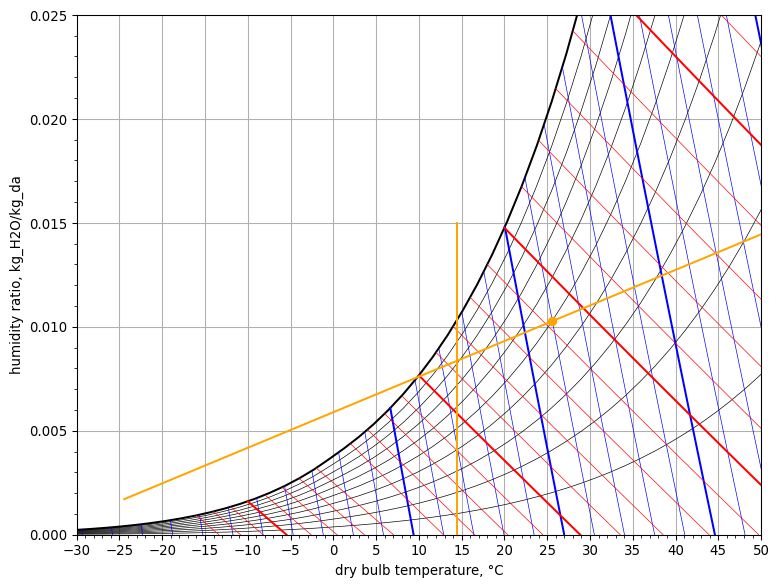

In [10]:
space_condition_line = SpaceConditionLine(
    space_air=zone_air,
    Q=Q_zone,
    SHR=SHR_zone
)

psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_space_condition_line(
    start_point=space_condition_line.start_point(),
    end_point=space_condition_line.end_point(),
    space_point=space_condition_line.space_point()
)
psych_chart.plot_line(
    name='line1',
    start_point=StatePoint(T_supply.to('degC'), Q_(0, 'g / kg')),
    end_point=StatePoint(T_supply.to('degC'), Q_(15, 'g / kg'))
)

psych_chart.show()

By choosing the supply air db-temperature, the supply air state is thus fully determined by the space condition line. Also, by specifying the supply air temperature, the required mass flow rate of supply air will be determined at the same time.   

In [11]:
zone = AirConditioningProcess(
    T_ai=T_supply,
    air_out=zone_air,
    Q=Q_zone,
    SHR=SHR_zone
)
supply_air = zone.air_in
m_supply = zone.m_da

ja.display_list([
    f"supply air state: <b>{supply_air.Tdb.to('degF'):~P.1f} TDB, {supply_air.W.to('lb / lb'):~P.5f} lb<sub>w</sub>/lb<sub>da</sub></b>",
    f"supply air mass flow rate: <b>{m_supply.to('lb / hr'):~P.0f}</b>"
])

### 2. Determine the Mixed Air Condition at the Entrance of the Cooling Coil 

First we determine the mass flow rate of outdoor ventilation air. As the supply air mass flow rate, which is the same as the mass flow rate of air through the cooling coil, has already been determined, the mass flow rate of recirculation air can also be determined.<br>
When the states of outdoor ventilation and recirculation air, together with their mass flow rates, and the mass flow rate of air through the cooling coil are known, the air state at the entrance of the cooling coil can be determined from adiabatic mixing. 

In [12]:
m_vent = outdoor_air.rho * V_vent
m_recir = m_supply - m_vent

ja.display_list([
    f"ventilation air mass flow rate: <b>{m_vent.to('lb / hr'):~P.0f}</b>",
    f"recirculation air mass flow rate: <b>{m_recir.to('lb / hr'):~P.0f}</b>"
])

In [13]:
outdoor_air_str = AirStream(state=outdoor_air, m_da=m_vent)
recir_air_str = AirStream(state=zone_air, m_da=m_recir)
mixed_air_str = AirStream(m_da=m_supply)

mixing_chamber = AdiabaticMixing(
    in1=outdoor_air_str,
    in2=recir_air_str,
    out=mixed_air_str
)
mixed_air = mixing_chamber.stream_out.state

ja.display_list([
    f"mixed air state: <b>{mixed_air.Tdb.to('degF'):~P.1f} TDB, {mixed_air.W.to('lb / lb'):~P.5f} lb<sub>w</sub>/lb<sub>da</sub></b>"
])

### 3. Determine Fan Heat and Air State at Cooling Coil Exit

The supply fan adds heat to the cooled air stream leaving the cooling coil due to inefficiencies of the fan and also of its motor, as it is also located within the airstream. To deliver the required mass flow rate of supply air to the space, the fan pressure rise in the example is 3 inWG. The efficiency of the fan is 70 %, while the fan motor efficiency is 84 %. The fan delivers the air to the space at the already determined supply air conditions.

In [14]:
supply_fan = Fan(
    air_out=supply_air,
    fan_pressure=Q_(3, 'inch_H2O_60F'),
    fan_efficiency=Q_(70, 'pct'),
    motor_efficiency=Q_(84, 'pct')
)
cooled_air = supply_fan.air_in

ja.display_list([
    f"cooled air state: <b>{cooled_air.Tdb.to('degF'):~P.1f} TDB, {cooled_air.W.to('lb / lb'):~P.5f} lb<sub>w</sub>/lb<sub>da</sub></b>"
])

### 4. Determine Cooling Coil Load

As the inlet and outlet air state at the cooling coil and the mass flow rate of air through the cooling coil are known, the cooling coil load (heat removal rate) can be determined from an energy balance of the cooling coil. In this balance the small enthalpy value of the water condensate that is removed from the air stream is ignored.

In [15]:
cooling_coil = AirConditioningProcess(
    air_in=mixed_air,
    air_out=cooled_air,
    m_da=m_supply,
)

ja.display_list([
    f"cooling coil load: <b>{cooling_coil.Q.to('Btu / hr'):~P.0f}<b>"
])

### Psychrometric Chart

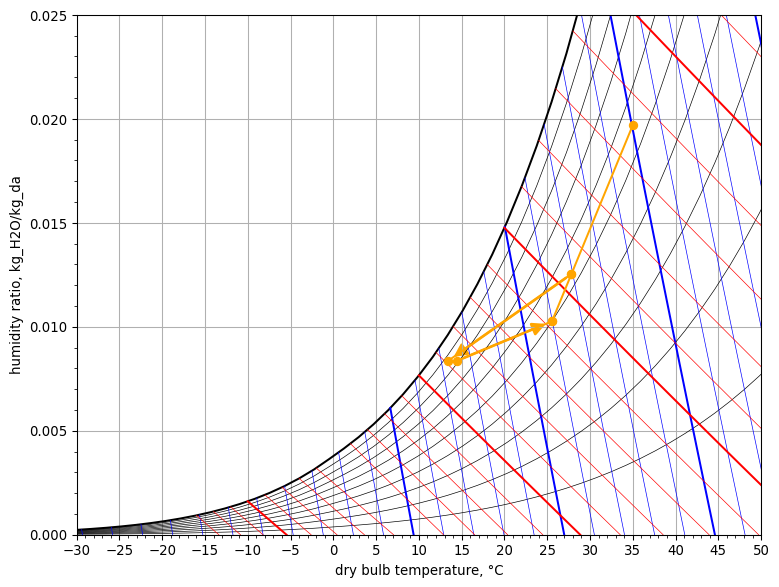

In [16]:
psych_chart = PsychrometricChart(fig_size=(8, 6))

psych_chart.plot_process(
    name='adiabatic mixing',
    start_point=StatePoint(outdoor_air.Tdb, outdoor_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W),
    mix_point=StatePoint(mixed_air.Tdb, mixed_air.W)
)

psych_chart.plot_process(
    name='cooling coil',
    start_point=StatePoint(mixed_air.Tdb, mixed_air.W),
    end_point=StatePoint(cooled_air.Tdb, cooled_air.W)
)

# psych_chart.plot_process(
#     name='fan heating',
#     start_point=StatePoint(cooled_air.Tdb, cooled_air.W),
#     end_point=StatePoint(supply_air.Tdb, supply_air.W)
# )

psych_chart.plot_process(
    name='space',
    start_point=StatePoint(supply_air.Tdb, supply_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W)
)

psych_chart.show()

## B. Summer Peak Design with High Latent Load

*We shall use the same design specifications as that of the CAV system analyzed under peak-load condition in Example 1 with one major difference. Instead of the space SHR being equal to 0.7, we are specified a value of 0.5, i.e., the sensible and latent loads are equal. The cooling coil leaving air temperature is as before, at 58F and 80% RH (the working conditions of the cooling coil, which are reflected by its ADP, remain unchanged). We will determine the supply air mass flow rate, and cooling coil and reheat coil loads in this case. The fan air temperature rise is ignored for simplicity. We will determine the supply air mass flow rate, and cooling coil and reheat coil loads in this case. The fan air temperature rise is ignored for simplicity.*

### 0. Design Conditions

The same design conditions as in section A apply, except the SHR of the zone.

In [17]:
SHR_zone = Q_(50, 'pct')

### 1. Determine the Supply Air Condition and Mass Flow Rate

When we draw the space condition line on the psychrometric chart, we see that it does not intersect with the saturation line.

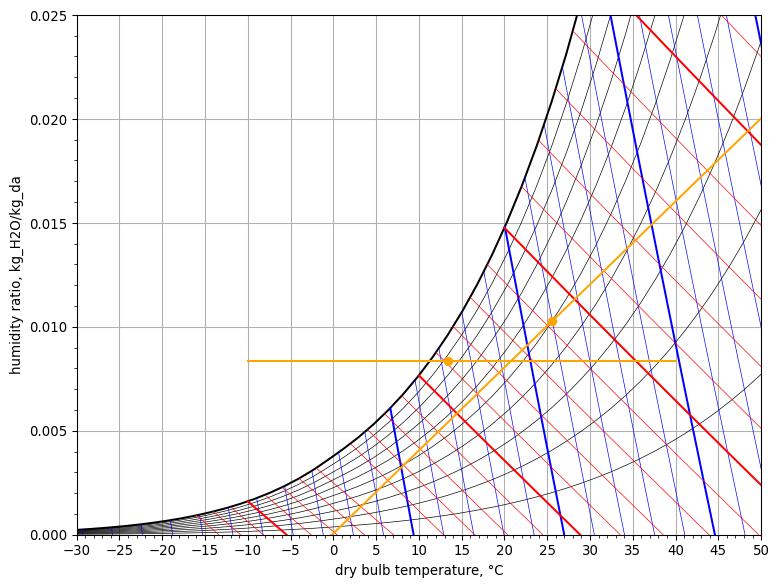

In [18]:
space_condition_line = SpaceConditionLine(
    space_air=zone_air,
    Q=Q_zone,
    SHR=SHR_zone
)

psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_space_condition_line(
    start_point=space_condition_line.start_point(),
    end_point=space_condition_line.end_point(),
    space_point=space_condition_line.space_point()
)
psych_chart.plot_line(
    name='line1',
    start_point=StatePoint(Q_(-10, 'degC'), cooled_air.W.to('kg / kg')),
    end_point=StatePoint(Q_(40, 'degC'), cooled_air.W.to('kg / kg'))
)
psych_chart.plot_point(
    name='point1',
    point=StatePoint(cooled_air.Tdb.to('degC'), cooled_air.W.to('kg / kg'))
)
psych_chart.show()

If we decide to keep the state of the cooled air leaving the cooling coil the same as in section A, we can determine the required state of the supply air with the humidity ratio of the cooled air, knowing that this can't change through the reheat coil and the supply fan:

In [19]:
zone = AirConditioningProcess(
    W_ai=cooled_air.W,
    air_out=zone_air,
    Q=Q_zone,
    SHR=SHR_zone
)
supply_air = zone.air_in
m_supply = zone.m_da

ja.display_list([
    f"supply air state: <b>{supply_air.Tdb.to('degF'):~P.1f} TDB, {supply_air.W.to('lb / lb'):~P.5f} lb<sub>w</sub>/lb<sub>da</sub></b>",
    f"supply air mass flow rate: <b>{m_supply.to('lb / hr'):~P.0f}</b>"
])

From the figure above, we see that we will have to heat the cooled air leaving the cooling coil in order to arrive onto the space condition line.

### 2. Determine Fan Heat and Air State at Reheat Coil Exit

In [20]:
supply_fan = Fan(
    air_out=supply_air,
    fan_pressure=Q_(3, 'inch_H2O_60F'),
    fan_efficiency=Q_(70, 'pct'),
    motor_efficiency=Q_(84, 'pct'),
    m_da=m_supply
)

reheat_air = supply_fan.air_in

ja.display_list([
    f"reheated air state: <b>{reheat_air.Tdb.to('degF'):~P.1f} TDB, {reheat_air.W.to('lb / lb'):~P.5f} lb<sub>w</sub>/lb<sub>da</sub></b>"
])

### 3. Determine Reheat Coil Load

In [21]:
reheat_coil = AirConditioningProcess(
    air_in=cooled_air,
    air_out=reheat_air,
    m_da=m_supply
)

ja.display_list([
    f"reheat coil load: <b>{reheat_coil.Q.to('Btu / hr'):~P.0f}</b>"
])

### 4. Determine the Mixed Air Condition at the Entrance of the Cooling Coil

In [22]:
m_recir = m_supply - m_vent

recir_air_str = AirStream(state=zone_air, m_da=m_recir)
mixed_air_str = AirStream(m_da=m_supply)

mixing_chamber = AdiabaticMixing(
    in1=outdoor_air_str,
    in2=recir_air_str,
    out=mixed_air_str
)
mixed_air = mixing_chamber.stream_out.state

ja.display_list([
    f"mixed air state: <b>{mixed_air.Tdb.to('degF'):~P.1f} TDB, {mixed_air.W.to('lb / lb'):~P.5f} lb<sub>w</sub>/lb<sub>da</sub></b>"
])

### 5. Determine Cooling Coil Load

In [23]:
cooling_coil = AirConditioningProcess(
    air_in=mixed_air,
    air_out=cooled_air,
    m_da=m_supply,
)

ja.display_list([
    f"cooling coil load: <b>{cooling_coil.Q.to('Btu / hr'):~P.0f}<b>"
])

### 6. Check the Energy Balance of the Entire System

**Ventilation load**

In [24]:
Q_vent = m_vent * (outdoor_air.h - zone_air.h)

ja.display_list([
    f"ventilation load: <b>{Q_vent.to('Btu / hr'):~P.0f}</b>"
])

**Total heat input**

In [25]:
Q_in_tot = Q_zone + Q_vent + supply_fan.Q + reheat_coil.Q

ja.display_list([
    f"total heat input: <b>{Q_in_tot.to('Btu / hr'):~P.0f}</b>"
])

The total heat input must (approximately) be equal to the total heat extracted from the system in the cooling coil.

### Psychrometric Chart

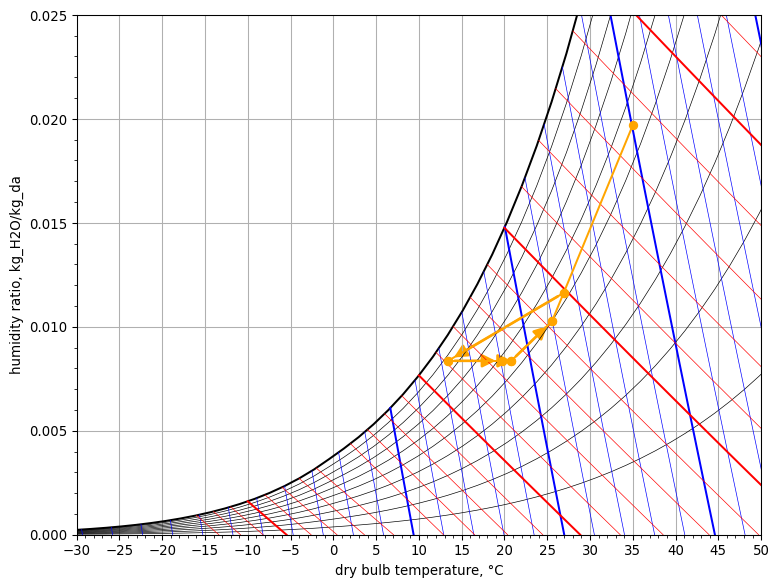

In [26]:
psych_chart = PsychrometricChart(fig_size=(8, 6))

psych_chart.plot_process(
    name='adiabatic mixing',
    start_point=StatePoint(outdoor_air.Tdb, outdoor_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W),
    mix_point=StatePoint(mixed_air.Tdb, mixed_air.W)
)

psych_chart.plot_process(
    name='cooling coil',
    start_point=StatePoint(mixed_air.Tdb, mixed_air.W),
    end_point=StatePoint(cooled_air.Tdb, cooled_air.W)
)

psych_chart.plot_process(
    name='reheat coil',
    start_point=StatePoint(cooled_air.Tdb, cooled_air.W),
    end_point=StatePoint(reheat_air.Tdb, reheat_air.W)
)

psych_chart.plot_process(
    name='fan heating',
    start_point=StatePoint(reheat_air.Tdb, reheat_air.W),
    end_point=StatePoint(supply_air.Tdb, supply_air.W)
)

psych_chart.plot_process(
    name='space',
    start_point=StatePoint(supply_air.Tdb, supply_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W)
)

psych_chart.show()

## C. Winter Peak Design

*Consider the CAV system analyzed under peak cooling load condition in Example 19.1. The same space is to be maintained at 72°F (25.5°C) and 50% RH. The total heating load of the space is 150,000 Btu/hr (44 kW) with an SHR of 0.8. The outdoor design condition is 40°F (4.4°C) dry bulb and 40% RH. The same amount of ventilation air 
(1000 ft³/min or 472 L/s) is needed. Design the necessary heating and humidification equipment assuming saturated steam at 200°F (93°C) is available and the supply airflow rate is kept at the summer design peak value of 17,140 lb/hr (2.2 kg/s). The supply air dry-bulb temperature should not exceed 105°F (40.5°C).*

### 0. Design Conditions

Zone air condition:

In [27]:
zone_air = HumidAir(Tdb=Q_(72.0, 'degF'), RH=Q_(50.0, 'pct'))

Heating load on winter peak design day:

In [28]:
Q_zone = Q_(-150_000, 'Btu / hr')  # minus sign: heat is removed from the room
SHR_zone = Q_(0.8, 'frac')

Outdoor air condition:

In [29]:
outdoor_air = HumidAir(Tdb=Q_(40, 'degF'), RH=Q_(40, 'pct'))

Ventilation air flow rate:

In [30]:
V_vent = Q_(1000, 'ft ** 3 / min')

Mass flow rate of supply air:

In [31]:
m_supply = Q_(17_140, 'lb / hr')

### 1. Determine the Condition of Mixed Air at Entrance of Preheat Coil

**Determine ventilation and recirculation mass flow rates**

In [32]:
m_vent = outdoor_air.rho * V_vent
m_recir = m_supply - m_vent

ja.display_list([
    f"ventilation mass flow rate: <b>{m_vent.to('lb / hr'):~P.0f}</b>",
    f"recirculation mass flow rate: <b>{m_recir.to('lb / hr'):~P.0f}</b>",
])

**Get mixed air condition from adiabatic mixing of outdoor ventilation air and recirculated air from space** 

In [33]:
outdoor_air_str = AirStream(state=outdoor_air, m_da=m_vent)
recir_air_str = AirStream(state=zone_air, m_da=m_recir)
mixed_air_str = AirStream(m_da=m_supply)

mixing_chamber = AdiabaticMixing(
    in1=outdoor_air_str,
    in2=recir_air_str,
    out=mixed_air_str
)
mixed_air = mixing_chamber.stream_out.state

ja.display_list([
    f"mixed air state: <b>{mixed_air.Tdb.to('degF'):~P.1f} TDB, {mixed_air.W.to('lb / lb'):~P.5f} lb<sub>w</sub>/lb<sub>da</sub></b>"
])

### 2. Determine the Condition of Supply Air to the Zone

In [34]:
zone = AirConditioningProcess(
    air_out=zone_air,
    m_da=m_supply,
    Q=Q_zone,
    SHR=SHR_zone
)
supply_air = zone.air_in

ja.display_list([
    f"supply air state: <b>{supply_air.Tdb.to('degF'):~P.1f} TDB, {supply_air.W.to('lb / lb'):~P.5f} lb<sub>w</sub>/lb<sub>da</sub></b>"
])

The humidity ratio of the supply air is greater than that of the mixed air. Consequently, we will need to humidify the mixed air to arrive at the required supply air state on the space condition line.

### 3. Determine the Amount of Steam in the Humidifier and the Condition of the Preheated Air

**Mass flow rate of steam**<br>
The needed mass flow rate of steam follows from the difference between the humidity ratio of the supply air and that of the mixed air.

In [35]:
m_steam = m_supply * (supply_air.W - mixed_air.W)

ja.display_list([
    f"steam injection rate: <b>{m_steam.to('lb / hr'):~P.3f}</b>"
])

The steam injected in the air stream is saturated dry steam at a temperature of 200 °F. 

In [36]:
Water = Fluid('Water')
steam = Water(T=Q_(200, 'degF'), x=Q_(100, 'pct'))

**Humidification process**<br>
From the humidification process using steam injection the air state at the entrance of the humidifier can be determined. This is also the air state at the exit of the preheater. In a humidification process only water is added to the air stream; there is no heat transfer with the air stream, so `Q` needs to be set to zero in order to solve this air conditioning process.

In [37]:
humidifier = AirConditioningProcess(
    W_ai=mixed_air.W,
    air_out=supply_air,
    m_da=m_supply,
    h_w=steam.h,
    m_w=m_steam,
    Q=Q_(0, 'Btu / lb')
)
preheated_air = humidifier.air_in

ja.display_list([
    f"preheated air state: <b>{preheated_air.Tdb.to('degF'):~P.1f} TDB, {preheated_air.W.to('lb / lb'):~P.5f} lb<sub>w</sub>/lb<sub>da</sub></b>"
])

### 4. Determine the Sensible Heating needed by the Preheat Coil

The condition of the mixed air at the entrance of the preheat coil and the condition of the air at the exit of the preheat coil are known. The required heating capacity of the preheat coil on the winter peak design day can then be determined.

In [38]:
preheat_coil = AirConditioningProcess(
    air_in=mixed_air,
    air_out=preheated_air,
    m_da=m_supply
)

ja.display_list([
    f"preheat coil capacity: <b>{preheat_coil.Q.to('Btu / hr'):~P.0f}</b>"
])

### 5. Check the Energy Balance of the Entire System

**Ventilation load**

In [39]:
Q_vent = m_vent * (outdoor_air.h - zone_air.h)

ja.display_list([
    f"ventilation load: <b>{Q_vent.to('Btu / hr'):~P.0f}</b>"
])

**Total energy output**

In [40]:
Q_out_tot = Q_zone + Q_vent

ja.display_list([
    f"total heat loss: <b>{Q_out_tot.to('Btu / hr'):~P.0f}</b>"
])

**Total heat input**

In [41]:
Q_in_tot = preheat_coil.Q + m_steam * steam.h

ja.display_list([
    f"total heat input: <b>{Q_in_tot.to('Btu / hr'):~P.0f}</b>"
])

### Psychrometric Chart

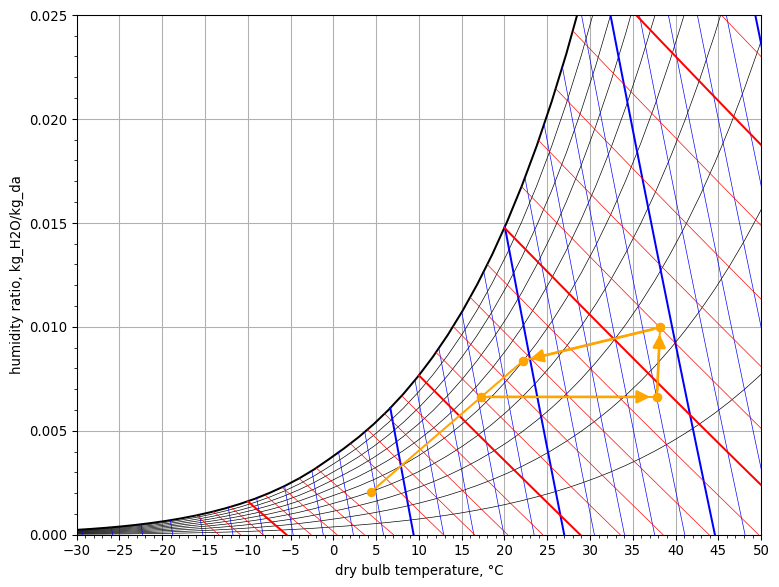

In [42]:
psych_chart = PsychrometricChart(fig_size=(8, 6))

psych_chart.plot_process(
    name='adiabatic mixing',
    start_point=StatePoint(outdoor_air.Tdb, outdoor_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W),
    mix_point=StatePoint(mixed_air.Tdb, mixed_air.W)
)

psych_chart.plot_process(
    name='preheat coil',
    start_point=StatePoint(mixed_air.Tdb, mixed_air.W),
    end_point=StatePoint(preheated_air.Tdb, preheated_air.W)
)

psych_chart.plot_process(
    name='steam injection',
    start_point=StatePoint(preheated_air.Tdb, preheated_air.W),
    end_point=StatePoint(supply_air.Tdb, supply_air.W)
)

psych_chart.plot_process(
    name='space',
    start_point=StatePoint(supply_air.Tdb, supply_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W)
)

psych_chart.show()